# Qualitative Bankruptcy Analysis
    a.    Examine the data description and build a classification model to predict the end point. 
    b.    Interpret the results and explain.

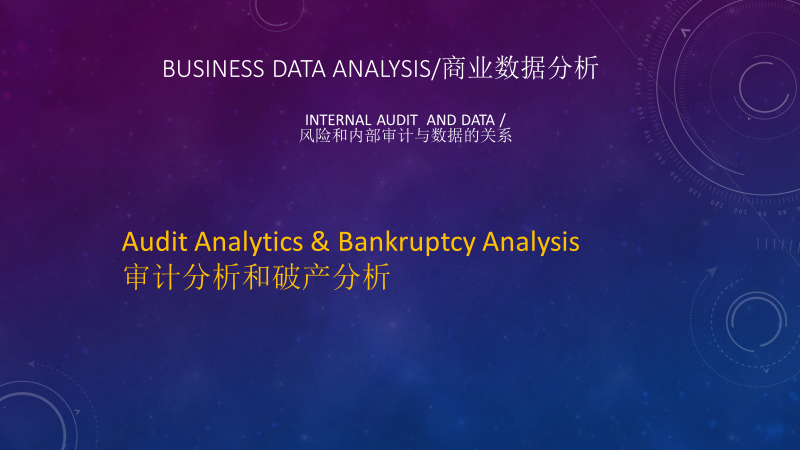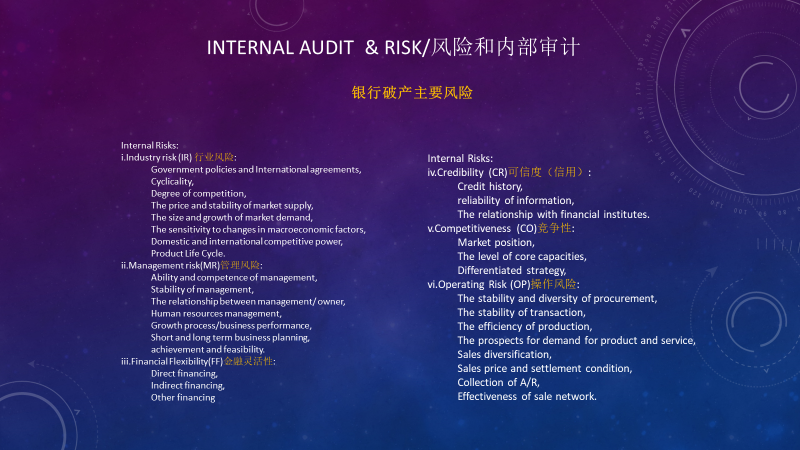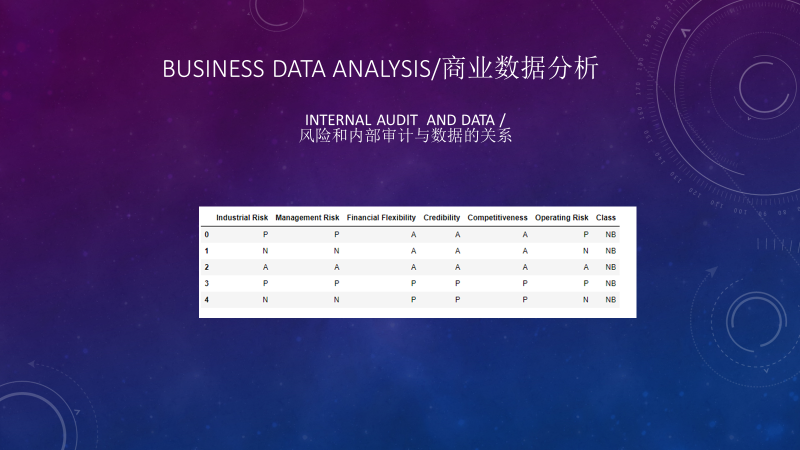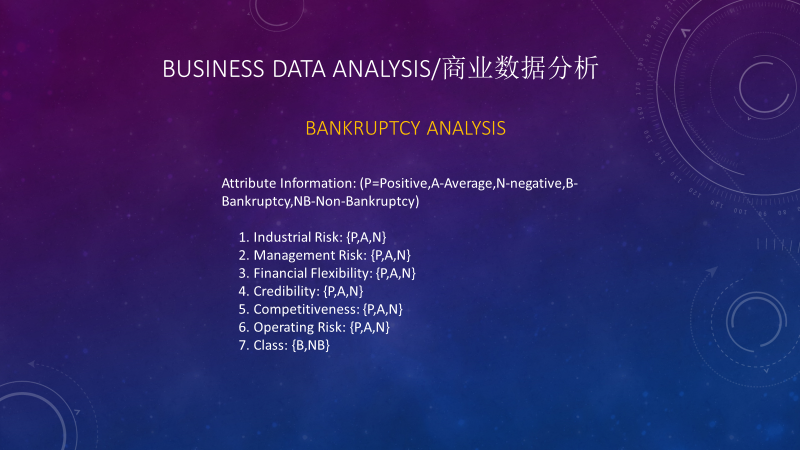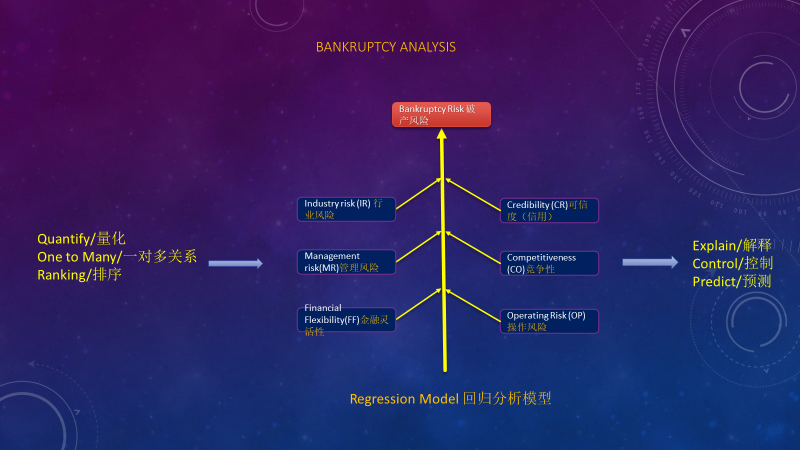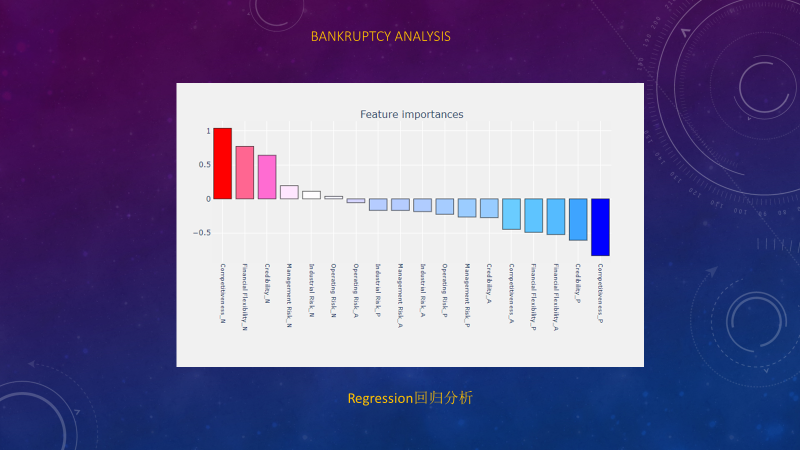

## Import Packages

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# %pip install yellowbrick --user
# %pip install plotly --user 

## Load data

In [71]:
import pyodbc
import urllib
import sqlalchemy

'''connect to datahub'''

params_datahub = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=datahub;"
                                 "UID=sa;"
                                 "PWD=user1")

engine_datahub = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_datahub))

In [72]:
# columns=['Industrial Risk','Management Risk','Financial Flexibility',
#          'Credibility','Competitiveness','Operating Risk','Class']
df=pd.read_sql_table("audit_qualitative_bankruptcy",engine_datahub)
df.head()

,Industrial Risk,Management Risk,Financial Flexibility,Credibility,Competitiveness,Operating Risk,Class
0,P,P,A,A,A,P,NB
1,N,N,A,A,A,N,NB
2,A,A,A,A,A,A,NB
3,P,P,P,P,P,P,NB
4,N,N,P,P,P,N,NB


# Exploratory Data Analysis(EDA) 

## Check missing values and shape
Normally we need to clean the samples, i,e., impute missing values but in this case the data is pretty clean with no missing values. We also check the shape to make sure it matches the meta data info in the document. 

In [73]:
df.info(), df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Industrial Risk        250 non-null    object
 1   Management Risk        250 non-null    object
 2   Financial Flexibility  250 non-null    object
 3   Credibility            250 non-null    object
 4   Competitiveness        250 non-null    object
 5   Operating Risk         250 non-null    object
 6   Class                  250 non-null    object
dtypes: object(7)
memory usage: 13.8+ KB


(None, (250, 7))

## Check Bankruptcy vs Non Bankruptcy ratio
The samples are balanced so we can use "Accuracy" metric to measure the performance of the model

<AxesSubplot:>

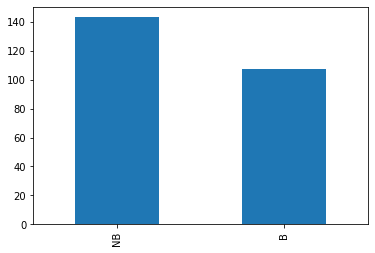

In [74]:
df.Class.value_counts().plot(kind='bar')

## Exploratory Data Analysis(EDA) --- Percentage



<Figure size 432x288 with 0 Axes>

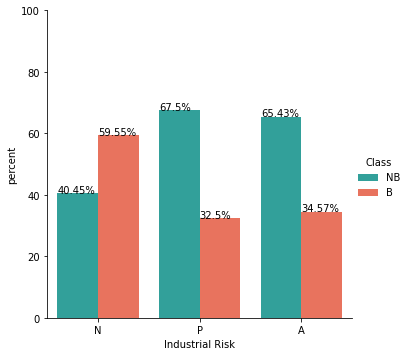

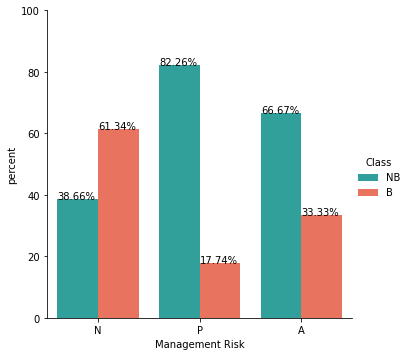

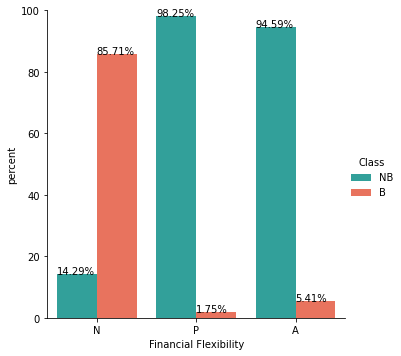

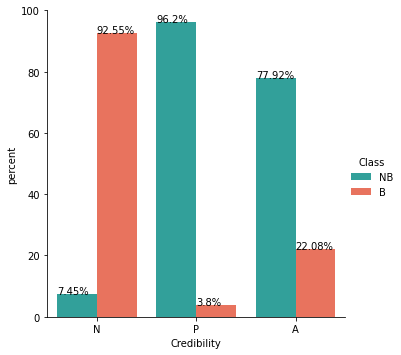

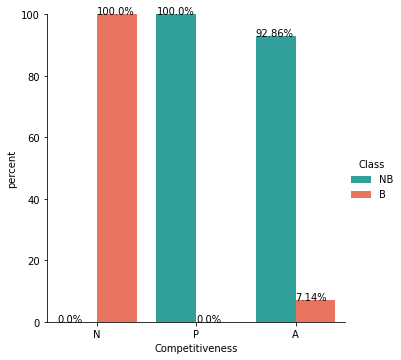

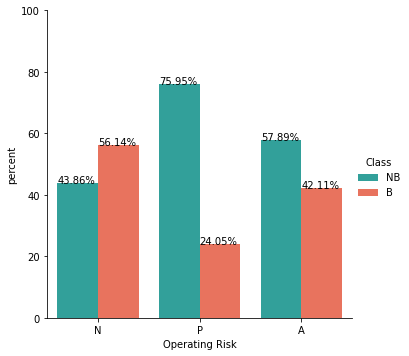

In [75]:
#Plot each attribute vs Class in percentage

y = 'Class'
for i, predictor in enumerate(df.drop(columns=['Class'])):
    plt.figure(i)
    df1 = df.groupby(predictor)[y].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()

    g = sns.catplot(x=predictor,y='percent',hue=y,kind='bar',data=df1,order = ['N', 'P', 'A'],
                    palette=sns.color_palette(['lightseagreen', 'tomato']))
    g.ax.set_ylim(0,100)

    for p in g.ax.patches:
        txt = str(np.nan_to_num(p.get_height().round(2))) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height()
        txt_y=np.nan_to_num(txt_y)
        g.ax.text(txt_x,txt_y,txt)

## Preliminary Analysis:
From the EDA we can see that Competitiveness, Credibility and Financial Flexibility are relatively important qualitative parameters in predicting bankruptcy. In the case of Competitiveness, if the value is N (negative), 100 %( 103 cases) of the instances/cases are bankrupt and if P (Positive) 100 %( 91 cases) not bankrupt. Therefore the ability to improve Market position, to achieve higher level of core capacities and to have Differentiated strategy is the key to remain in the business. Similarly for Credibility, negative credibility has 93% bankruptcy rate and for Financial Flexibility negative value has 86% bankruptcy rate. Therefore we know that credibility is critical for a bank, you lose it you lose the business. Financial Flexibility allows us to borrow money and maintain high liquidity when needed and hence is important especially in difficult times like financial crisis.
As for the risk group attributes(Industrial Risk, Management Risk, Operating Risk),from the charts we can see when the risks are positive, it makes a big difference. For the risk group attribute, if it's positive the Non-Bankruptcy percentage are 67.5%, 82.3% and 76.0% for Industrial Risk, Management Risk, and Operating Risk respectively. This means reducing the risks does pay off in terms of keeping the business alive.






## Exploratory Data Analysis(EDA) --- Counts
This is to confirm the percentage analysis.

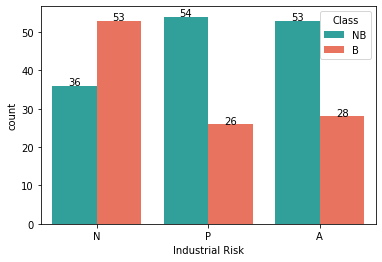

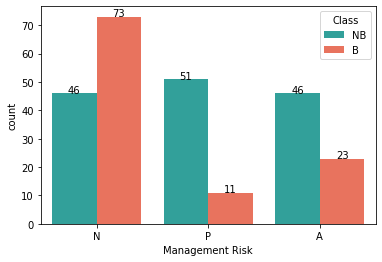

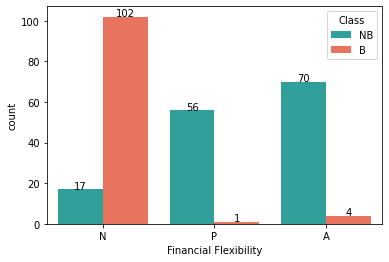

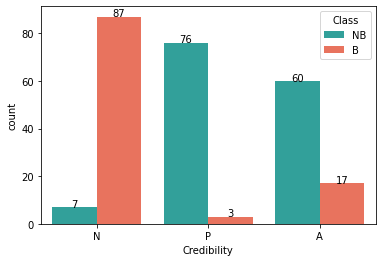

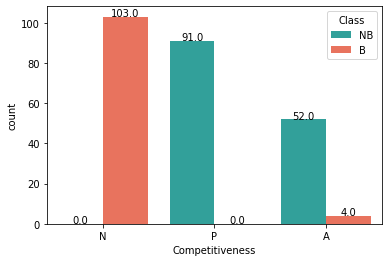

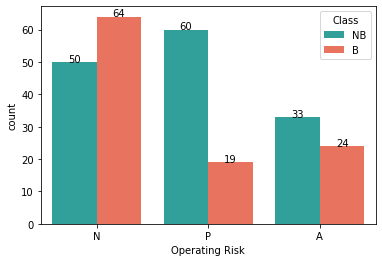

In [76]:
for i, predictor in enumerate(df.drop(columns=['Class'])):
    plt.figure(i)
    g1=sns.countplot(data=df, x=predictor, hue='Class',order = ['N', 'P', 'A'],palette=sns.color_palette(['lightseagreen', 'tomato']))

    for p in g1.patches:
        height = p.get_height()
        height=np.nan_to_num(height)
        g1.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
      

## Exploratory Data Analysis(EDA) ---Associations among attributes
For categorical attributes we can use Cramér’s V to generate a heatmap like correlation heatmap for numerical attributes. 
It is based on a nominal variation of Pearson’s Chi-Square Test

# Data processing and Model building

## Prepare features for model training

In [77]:
# define encode function to encode categoritcal features
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop([each], axis=1)
    return df

#Lable Class attribute
df_class = np.where(df['Class']=='NB',0,1)

#encode categorical features
df_encoded=one_hot(df.drop(columns=['Class']),df.drop(columns=['Class']).columns)
df_encoded.head()

,Industrial Risk_A,Industrial Risk_N,Industrial Risk_P,Management Risk_A,Management Risk_N,Management Risk_P,Financial Flexibility_A,Financial Flexibility_N,Financial Flexibility_P,Credibility_A,Credibility_N,Credibility_P,Competitiveness_A,Competitiveness_N,Competitiveness_P,Operating Risk_A,Operating Risk_N,Operating Risk_P
0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1
1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0
2,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
3,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1
4,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0


In [78]:
df_x=df_encoded

In [79]:
df_y=df_class

In [80]:
df_x

,Industrial Risk_A,Industrial Risk_N,Industrial Risk_P,Management Risk_A,Management Risk_N,Management Risk_P,Financial Flexibility_A,Financial Flexibility_N,Financial Flexibility_P,Credibility_A,Credibility_N,Credibility_P,Competitiveness_A,Competitiveness_N,Competitiveness_P,Operating Risk_A,Operating Risk_N,Operating Risk_P
0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1
1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0
2,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
3,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1
4,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0
246,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0
247,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0
248,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0


In [81]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score


                   
#splitting the principal training dataset to subtrain and subtest datasets
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = .3)

from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()

logit.fit(x_train, y_train)
predictions = logit.predict(x_test)
probabilities = logit.predict_proba(x_test)
    
print('Algorithm:', type(logit).__name__)
print("\nClassification report:\n", classification_report(y_test, predictions))
print("Accuracy Score:", accuracy_score(y_test, predictions))

Algorithm: LogisticRegression

Classification report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99        38
           1       1.00      0.97      0.99        37

    accuracy                           0.99        75
   macro avg       0.99      0.99      0.99        75
weighted avg       0.99      0.99      0.99        75

Accuracy Score: 0.9866666666666667


In [82]:
#confusion matrix
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.offline as py
conf_matrix = confusion_matrix(y_test, predictions)

trace=go.Heatmap(z = conf_matrix,x = ["0", "1"],y = ["0", "1"],showscale = False, colorscale = "Picnic")
fig = make_subplots()
fig.add_trace(trace)
py.iplot(fig)

In [83]:
column_df = pd.DataFrame(x_train.columns.tolist())
coefficients = pd.DataFrame(logit.coef_.ravel())
coef_sumry = (pd.merge(coefficients, column_df, left_index=True, 
                               right_index=True, how="left"))
coef_sumry.columns = ["coefficients", "features"]
coef_sumry = coef_sumry.sort_values(by = "coefficients", ascending=False)
display(coef_sumry)
trace = go.Bar(x = coef_sumry["features"], y = coef_sumry["coefficients"])


fig = make_subplots()
fig.add_trace(trace)
py.iplot(fig)

,coefficients,features
13,2.210396,Competitiveness_N
7,1.588800,Financial Flexibility_N
10,1.483414,Credibility_N
4,0.588752,Management Risk_N
1,0.309065,Industrial Risk_N
16,0.189680,Operating Risk_N
15,0.056147,Operating Risk_A
2,-0.017563,Industrial Risk_P
3,-0.218856,Management Risk_A
17,-0.245805,Operating Risk_P


In [84]:
df

,Industrial Risk,Management Risk,Financial Flexibility,Credibility,Competitiveness,Operating Risk,Class
0,P,P,A,A,A,P,NB
1,N,N,A,A,A,N,NB
2,A,A,A,A,A,A,NB
3,P,P,P,P,P,P,NB
4,N,N,P,P,P,N,NB
...,...,...,...,...,...,...,...
245,N,N,A,N,N,N,B
246,P,N,N,N,N,N,B
247,A,N,N,N,N,N,B
248,N,N,N,N,N,N,B


# Interpret the results:
An Accuracy Score of 0.98 on Test data is a very good score with 1 being perfect 100% correct prediction. 
From the confusion Matrix we know that out of 63 prediction, only one mistake. Area under curve(True Positive/ False Positive), 
another model performance metric which often is used for unbalanced samples, is 0.985, also near perfect. The Feature Importance chart(Red means positive correlated with Bankruptcy and blue negative)  confirms that  Competitiveness, Credibility and Financial Flexibility are more powerful predictors. And positive risks do predict Non Bankruptcy. 

Overall we have a very good model that can predict Bankruptcy or Non Bankruptcy.
